In [6]:
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D

from libs.utils import *
from libs.generate_boxes import  *

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [17]:
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(ActorCritic, self).__init__()
        self.case_cnn1 = Conv2D(filters=32, kernel_size=3, activation='relu', 
                                padding="valid", input_shape = selected_size)
        self.case_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu', 
                                padding="valid")

        self.select_cnn1 = Conv2D(filters=32, kernel_size=3, activation='relu', 
                                  padding="valid", input_shape = selected_size)
        self.select_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu', 
                                  padding="valid")
        
        cs_size = state_size[:2] + (state_size[2] + selected_size[2],)
        self.case_loc_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                   padding = 'valid', input_shape = cs_size)
        self.case_loc_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                   padding = 'valid')
        
        self.remain_cnn1 = Conv1D(filters=32, kernel_size=2, activation='relu', 
                                  padding="same", input_shape = remain_size)
        self.remain_cnn2 = Conv1D(filters=32, kernel_size=2, activation='relu', 
                                  padding="same")
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.out = Dense(output_size)
        
    def call(self, cb_list):
        c, s, r = cb_list[0], cb_list[1], cb_list[2]
        cs = tf.concat([c,s],-1)

        c = self.case_cnn1(c)
        c = MaxPooling2D(pool_size=(2, 2))(c)
        c = self.case_cnn2(c)
        c = MaxPooling2D(pool_size=(2, 2))(c)
        c = Flatten()(c)

        s = self.select_cnn1(s)
        s = MaxPooling2D(pool_size=(2, 2))(s)
        s = self.select_cnn2(s)
        s = MaxPooling2D(pool_size=(2, 2))(s)
        s = Flatten()(s)
        
        cs = self.case_loc_cnn1(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = self.case_loc_cnn2(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = Flatten()(cs)

        r = self.remain_cnn1(r)
        r = self.remain_cnn2(r)
        r = MaxPooling1D(pool_size=1)(r)
        r = Flatten()(r)
        
        x = concatenate([c,s,cs,r])
        x = self.d1(x)
        x = self.d2(x)
        q = self.out(x)
        return q

In [18]:
class ActorCriticAgent:
    def __init__(self, L=20,B=20,H=20,n_remains=5,lr=1e-8,gamma=0.99):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (n_remains, 3)
        self.output_size = 1
        
        self.lr = lr
        self.gamma = gamma
        
        self.actor = ActorCritic(self.state_size, self.selected_size,
                          self.remain_size, self.output_size)
        self.critic = ActorCritic(self.state_size, self.selected_size,
                           self.remain_size, self.output_size)
        
        self.actor_optimizer = Adam(learning_rate = self.lr)
        self.critic_optimizer = Adam(learning_rate = self.lr)
        
        self.memory = deque(maxlen=500)
        
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def append_sample(self, history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains):
        self.memory.append((history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains))
        
    def get_action(self, state, s_locs, r_boxes):
        actor = self.actor([state, s_locs, r_boxes])
        argmax_idx = np.where(actor == tf.math.reduce_max(actor))
        action_idx = argmax_idx[0][0]
        return action_idx
    
    def get_actor_loss():
        pass
    
    def get_critic_loss():
        pass
    
    def train(self):
        batch = random.sample(self.memory, len(self.memory))
        
        history = np.array([sample[0] for sample in batch])
        s_boxes = np.array([sample[1] for sample in batch])
        remains = np.array([sample[2] for sample in batch])
        action = np.array([sample[3] for sample in batch])
        reward = np.array([sample[4] for sample in batch])
        dones = np.array([sample[5] for sample in batch])
        next_history = [sample[6] for sample in batch]
        next_s_boxes = [sample[7] for sample in batch]
        next_remains = [sample[8] for sample in batch]
        
        #print(history.shape, s_boxes.shape, remains.shape, action.shape, reward.shape, dones.shape)
        #print(len(next_history), len(next_s_boxes), len(next_remains))
        #print(next_history[0].shape, next_s_boxes[0].shape, next_remains[0].shape)
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor = self.actor([history, s_boxes, remains])
            value = self.critic([history, s_boxes, remains])
            
            targets = []
            action_idx = np.stack([np.arange(len(self.memory)),action],axis=1)
            acts = tf.gather_nd(actor, action_idx, batch_dims=0, name=None)
            predicts = tf.gather_nd(value, action_idx, batch_dims=0, name=None)
            
            for i in range(len(self.memory)):
                next_value = self.critic([next_history[i],next_s_boxes[i],
                                         next_remains[i]])
                next_max_value = tf.math.reduce_max(next_value)
                targets.append([(1-0.875)*reward[i] + (1-dones[i])*0.75*next_max_value])
            
            targets = np.array(targets)
            actor_loss = tf.reduce_mean(tf.square(targets - acts))
            critic_loss = tf.reduce_mean(tf.square(targets - predicts))
            
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
        
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads,
                                                self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads,
                                                 self.critic.trainable_variables))

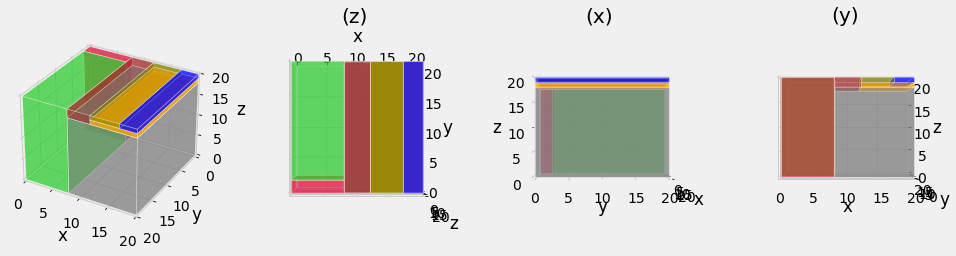

=====episode:     0 | memory length:     3 | env.terminal_reward(): 0.460 | avg actor loss : 0.000581 avg critic loss : 0.000827 time: 2.015
=====episode:     1 | memory length:     3 | env.terminal_reward(): 1.000 | avg actor loss : 0.028901 avg critic loss : 0.007731 time: 1.881
=====episode:     2 | memory length:     3 | env.terminal_reward(): 0.460 | avg actor loss : 0.026323 avg critic loss : 0.019143 time: 1.980
=====episode:     3 | memory length:     2 | env.terminal_reward(): 0.993 | avg actor loss : 0.056875 avg critic loss : 0.056875 time: 2.354
=====episode:     4 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.011851 avg critic loss : 0.011174 time: 1.677
=====episode:     5 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.010324 avg critic loss : 0.009314 time: 1.635
=====episode:     6 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.012425 avg critic loss : 0.012337 time: 1.739
=====episode:

=====episode:    59 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044346 avg critic loss : 0.044346 time: 1.539
=====episode:    60 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044452 avg critic loss : 0.044452 time: 1.531
=====episode:    61 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044547 avg critic loss : 0.044547 time: 1.493
=====episode:    62 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044633 avg critic loss : 0.044633 time: 1.572
=====episode:    63 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044711 avg critic loss : 0.044711 time: 1.594
=====episode:    64 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044782 avg critic loss : 0.044782 time: 1.583
=====episode:    65 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.044846 avg critic loss : 0.044846 time: 1.538
=====episode:

=====episode:   118 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045452 avg critic loss : 0.045452 time: 1.583
=====episode:   119 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045452 avg critic loss : 0.045452 time: 1.559
=====episode:   120 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045452 avg critic loss : 0.045452 time: 1.604
=====episode:   121 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045452 avg critic loss : 0.045452 time: 1.590
=====episode:   122 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045453 avg critic loss : 0.045453 time: 1.605
=====episode:   123 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045453 avg critic loss : 0.045453 time: 1.625
=====episode:   124 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045453 avg critic loss : 0.045453 time: 1.610
=====episode:

=====episode:   177 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.557
=====episode:   178 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.515
=====episode:   179 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.506
=====episode:   180 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.579
=====episode:   181 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.539
=====episode:   182 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.598
=====episode:   183 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.755
=====episode:

=====episode:   236 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.551
=====episode:   237 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.582
=====episode:   238 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.618
=====episode:   239 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.549
=====episode:   240 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.567
=====episode:   241 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.622
=====episode:   242 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.576
=====episode:

=====episode:   295 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.558
=====episode:   296 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.612
=====episode:   297 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.572
=====episode:   298 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.582
=====episode:   299 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.600
=====episode:   300 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.640
=====episode:   301 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.532
=====episode:

=====episode:   354 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.755
=====episode:   355 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 2.031
=====episode:   356 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.767
=====episode:   357 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 2.141
=====episode:   358 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.612
=====episode:   359 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.545
=====episode:   360 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.587
=====episode:

=====episode:   413 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.630
=====episode:   414 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.611
=====episode:   415 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.678
=====episode:   416 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.593
=====episode:   417 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.671
=====episode:   418 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.717
=====episode:   419 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.638
=====episode:

=====episode:   472 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.593
=====episode:   473 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.545
=====episode:   474 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.525
=====episode:   475 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.544
=====episode:   476 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.523
=====episode:   477 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.527
=====episode:   478 | memory length:     2 | env.terminal_reward(): 0.960 | avg actor loss : 0.045454 avg critic loss : 0.045454 time: 1.562
=====episode:

In [22]:
max_episode = 500
N_MDD = 7
K = 3
N_candidates = 4

boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)

num_max_boxes = len(boxes[0])
num_max_remain = num_max_boxes - K
env = Bpp3DEnv()
agent = ActorCriticAgent(L=20,B=20,H=20,n_remains=num_max_remain,
                        lr=0.001,gamma=0.99)

used_box_list, pred_pos_list = [], []
box_list, pos_list = [],[]
tr_l, h_fill, avg_actor_loss, avg_critic_loss, history_eps, used_boxes_eps = [],[],[],[],[],[]
vis_box_subplot(boxes[0], gt_pos[0])

for episode in range(max_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history, used_boxes, remains, comb, pred_pos, actions, s_orders = [],[],[],[],[],[],[]
    next_history, next_comb, next_remains, next_s_orders = [],[],[],[]
    
    boxes_all = np.array(boxes)[0].copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container.copy()
        k = min(K, len(r_boxes))
        step += 1
        
        selected = cbn_select_boxes(r_boxes[:N_candidates], k)
        s_order = get_selected_order(selected, k)
        
        state_h = env.update_h().copy()
        in_state, in_r_boxes = raw_to_input(state_h, s_order,
                                           r_boxes, num_max_remain)
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                             env.height) for s_loc in s_loc_c])
        
        action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        history.append(in_state[action_idx])
        s_loc = s_loc_c[action_idx]
        loaded_mh = get_loaded_mh(s_loc, env.length, env.breadth, env.height)
        comb.append(loaded_mh)
        
        actions.append(action_idx)
        remains.append(in_r_boxes[action_idx])
        env.convert_state(next_cube_c[action_idx])
        
        next_state = env.container.copy()
        next_state_h = env.container_h.copy()
        next_history.append(next_state_h)
        
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes_c[action_idx]
        pred_pos = pred_pos_c[action_idx]
        
        if len(r_boxes) == 0:
            done = True
            next_remains.append(np.zeros((num_max_remain, 3)))
            next_comb.append(np.zeros((1,20,20,2)))
            next_s_orders.append(np.zeros((1,1,3)))
        else:
            next_remains.append(r_boxes)
            k = min(K, len(r_boxes))
            selected = cbn_select_boxes(r_boxes[:N_candidates], k)
            s_order = get_selected_order(selected, k)
            s_loc_c, _,_,_,_,_ = get_selected_location(s_order, pred_pos,
                                                      used_boxes, next_state)
            loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                                 env.height) for s_loc in s_loc_c])
            next_comb.append(loaded_mh_c)
            next_s_orders.append(s_order)
            
            if np.sum(env.container_h != env.height) == 0:
                done = True
                
        if done:
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            
            is_last = False
            N = len(history)
            for i in range(N):
                if i == N-1:
                    is_last = True
                reward = (agent.gamma ** (N-i-1)) * terminal_reward
                in_next_history, in_next_remains = raw_to_input(next_history[i],
                                                               next_s_orders[i],
                                                               next_remains[i],
                                                               num_max_remain)
                
                agent.append_sample(history[i], comb[i], remains[i], actions[i],
                                   reward, is_last, in_next_history,
                                   next_comb[i], in_next_remains)
            agent.train()
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
            used_box_list.append(used_boxes)
            pred_pos_list.append(pred_pos)

    log = "=====episode: {:5d} | ".format(episode)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "env.terminal_reward(): {:.3f} | ".format(env.terminal_reward())
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss = 0
    agent.avg_critic_loss = 0
    agent.memory.clear()

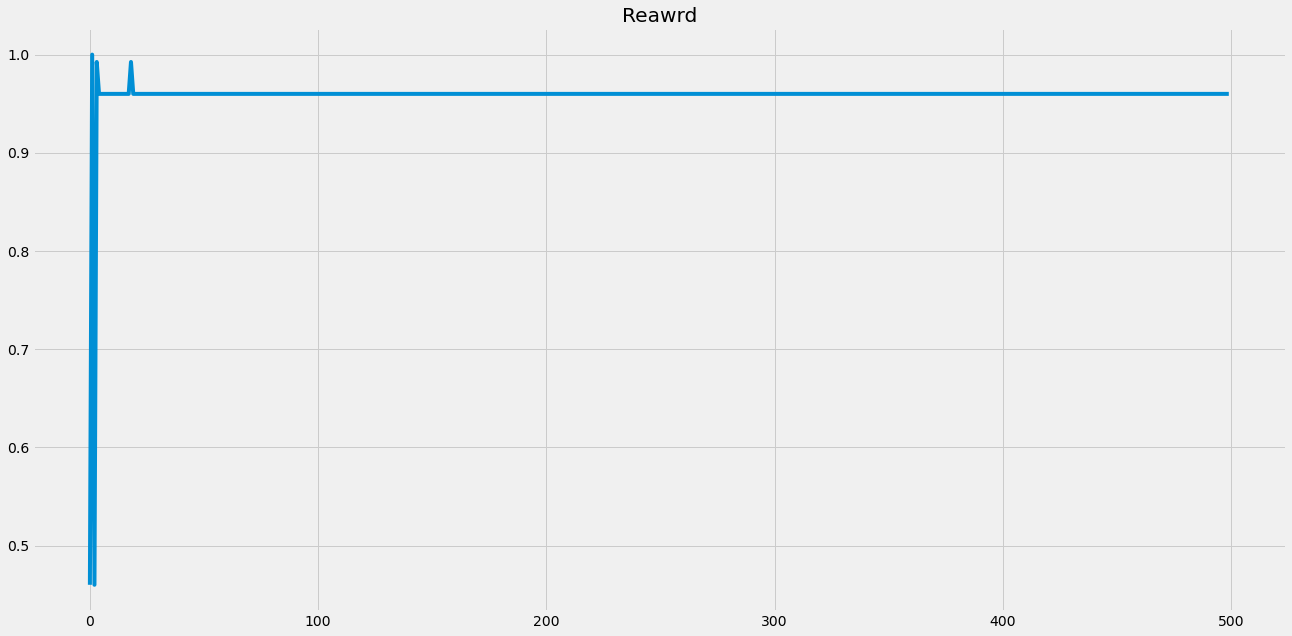

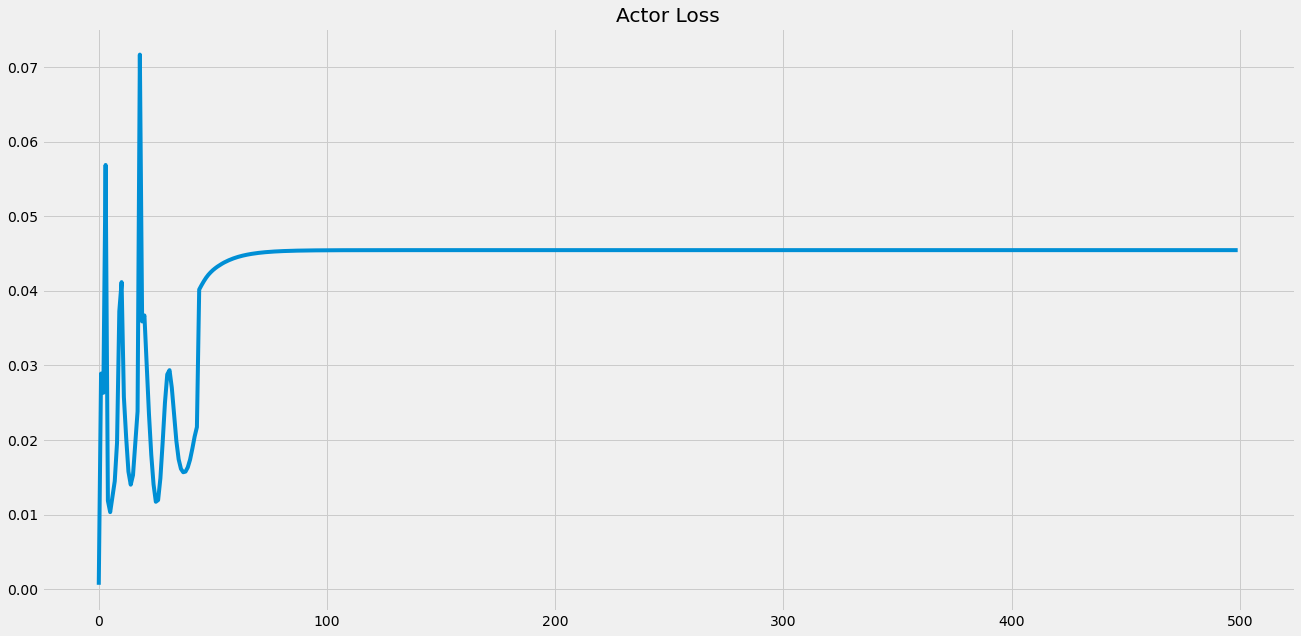

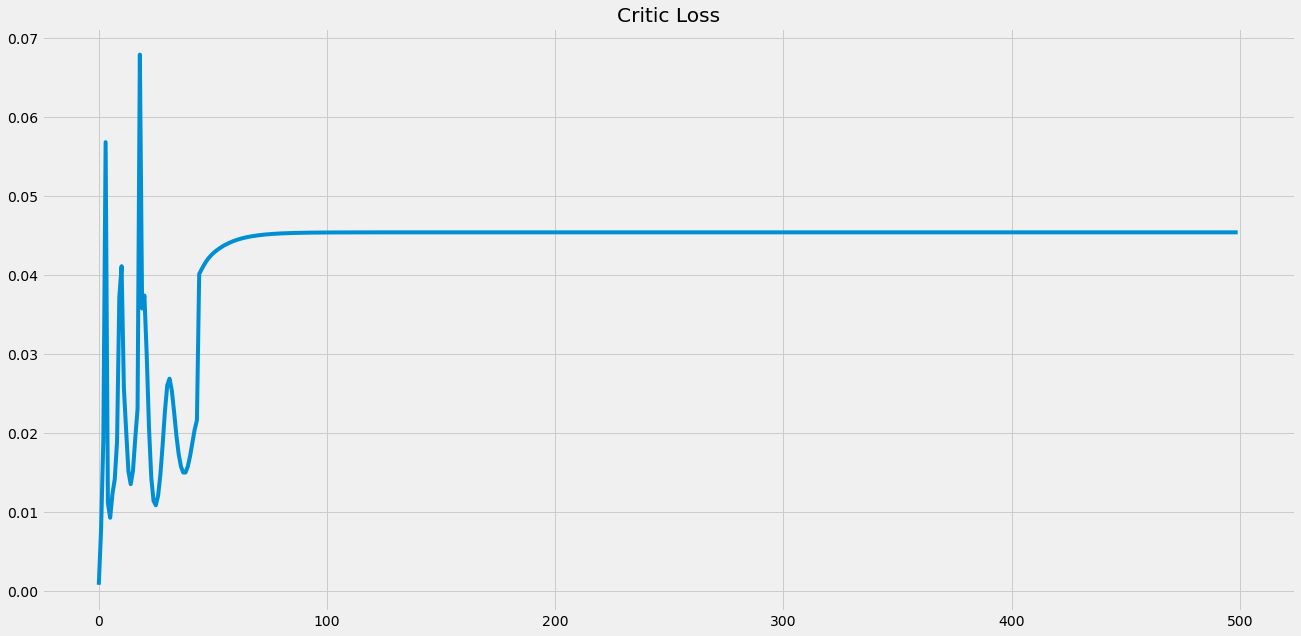

In [24]:
plt.title('Reawrd')
plt.plot(tr_l)
plt.show()

plt.title('Actor Loss')
plt.plot(avg_actor_loss)
plt.show()

plt.title('Critic Loss')
plt.plot(avg_critic_loss)
plt.show()

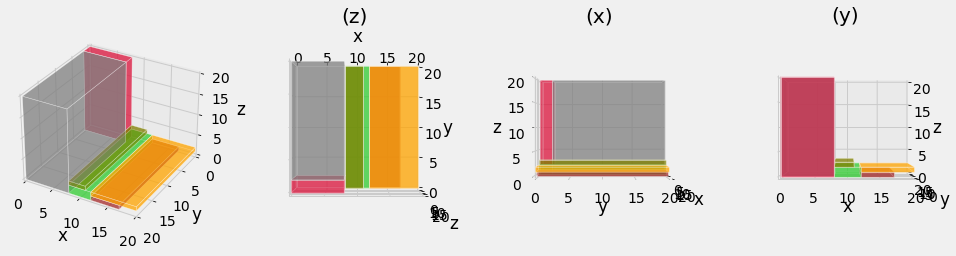

reward: 0.46 actor loss: 0.00058063263228784 critic_loss: 0.0008273029234260321


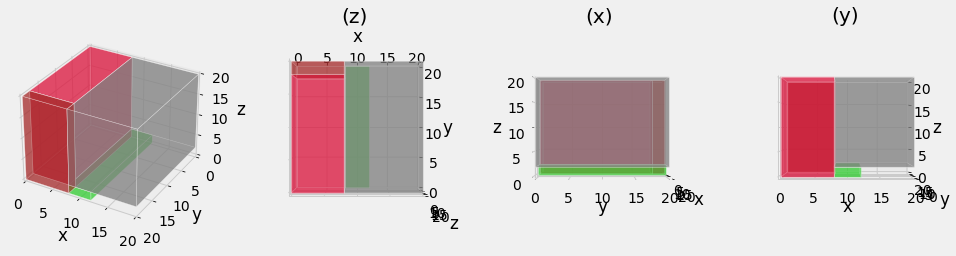

reward: 0.96 actor loss: 0.045436181128025055 critic_loss: 0.045436181128025055


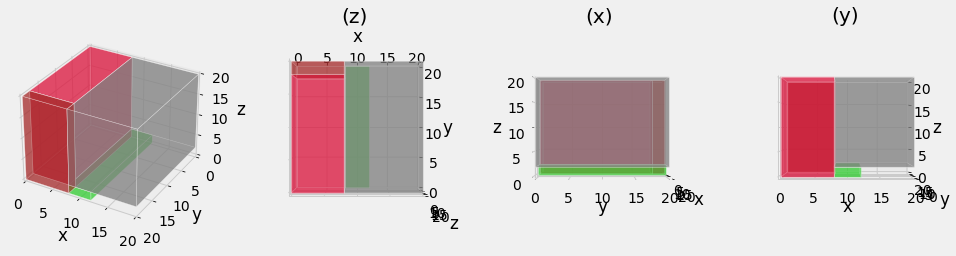

reward: 0.96 actor loss: 0.045454420149326324 critic_loss: 0.045454420149326324


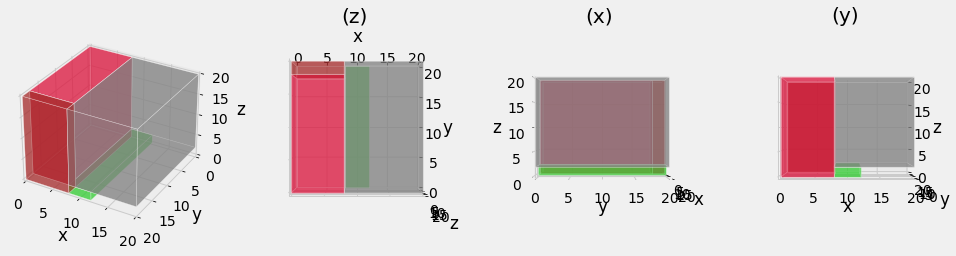

reward: 0.96 actor loss: 0.045454420149326324 critic_loss: 0.045454420149326324


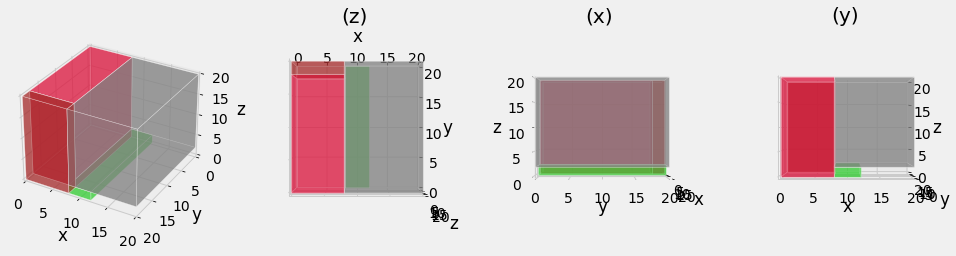

reward: 0.96 actor loss: 0.045454420149326324 critic_loss: 0.045454420149326324


In [27]:
for reward, act_loss, critic_loss, used_boxes, pred_pos in zip(tr_l[::100], avg_actor_loss[::100], avg_critic_loss[::100], used_box_list[::100], pred_pos_list[::100]):
    vis_box_subplot(used_boxes, pred_pos)
    print('reward:',reward,'actor loss:',act_loss,'critic_loss:',critic_loss)

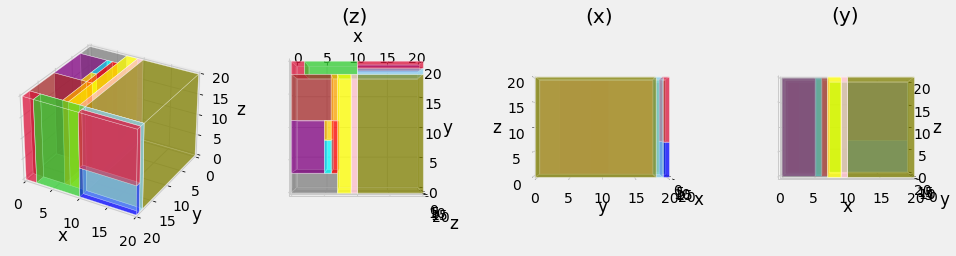

=====episode:     0 | memory length:     7 | env.terminal_reward(): 0.550 | avg actor loss : 0.004210 avg critic loss : 0.001194 time: 6.654
=====episode:     1 | memory length:     7 | env.terminal_reward(): 0.550 | avg actor loss : 0.005095 avg critic loss : 0.005139 time: 5.928
=====episode:     2 | memory length:     9 | env.terminal_reward(): 0.823 | avg actor loss : 0.004875 avg critic loss : 0.004630 time: 8.199
=====episode:     3 | memory length:     8 | env.terminal_reward(): 0.922 | avg actor loss : 0.005778 avg critic loss : 0.004398 time: 6.758
=====episode:     4 | memory length:     9 | env.terminal_reward(): 0.922 | avg actor loss : 0.007560 avg critic loss : 0.007562 time: 7.395
=====episode:     5 | memory length:     7 | env.terminal_reward(): 0.550 | avg actor loss : 0.009498 avg critic loss : 0.009051 time: 6.019
=====episode:     6 | memory length:     7 | env.terminal_reward(): 0.550 | avg actor loss : 0.007070 avg critic loss : 0.007381 time: 6.103
=====episode:

=====episode:    59 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.007712 avg critic loss : 0.007712 time: 6.004
=====episode:    60 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.007804 avg critic loss : 0.007804 time: 6.078
=====episode:    61 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.007966 avg critic loss : 0.007966 time: 5.801
=====episode:    62 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.008135 avg critic loss : 0.008135 time: 5.629
=====episode:    63 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.008254 avg critic loss : 0.008254 time: 5.950
=====episode:    64 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.008277 avg critic loss : 0.008277 time: 5.816
=====episode:    65 | memory length:     7 | env.terminal_reward(): 0.810 | avg actor loss : 0.008195 avg critic loss : 0.008196 time: 6.043
=====episode:

=====episode:   118 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008203 avg critic loss : 0.008203 time: 5.974
=====episode:   119 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008196 avg critic loss : 0.008195 time: 6.023
=====episode:   120 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008207 avg critic loss : 0.008207 time: 5.910
=====episode:   121 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008232 avg critic loss : 0.008231 time: 5.865
=====episode:   122 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008261 avg critic loss : 0.008260 time: 5.676
=====episode:   123 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008284 avg critic loss : 0.008284 time: 5.604
=====episode:   124 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008294 avg critic loss : 0.008294 time: 5.652
=====episode:

=====episode:   177 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008256 avg critic loss : 0.008256 time: 5.738
=====episode:   178 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008256 avg critic loss : 0.008256 time: 5.933
=====episode:   179 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008256 avg critic loss : 0.008256 time: 6.087
=====episode:   180 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008257 avg critic loss : 0.008257 time: 6.007
=====episode:   181 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.920
=====episode:   182 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008260 avg critic loss : 0.008260 time: 5.925
=====episode:   183 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008260 avg critic loss : 0.008260 time: 6.222
=====episode:

=====episode:   236 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.861
=====episode:   237 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.712
=====episode:   238 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.711
=====episode:   239 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 6.462
=====episode:   240 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 6.159
=====episode:   241 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.905
=====episode:   242 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.962
=====episode:

=====episode:   295 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.711
=====episode:   296 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.699
=====episode:   297 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.652
=====episode:   298 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.744
=====episode:   299 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.726
=====episode:   300 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.686
=====episode:   301 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.798
=====episode:

=====episode:   354 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.628
=====episode:   355 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 6.069
=====episode:   356 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 6.482
=====episode:   357 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.722
=====episode:   358 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 6.027
=====episode:   359 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.898
=====episode:   360 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.908
=====episode:

=====episode:   413 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.864
=====episode:   414 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.727
=====episode:   415 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.663
=====episode:   416 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.501
=====episode:   417 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.518
=====episode:   418 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.530
=====episode:   419 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.638
=====episode:

=====episode:   472 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.479
=====episode:   473 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.476
=====episode:   474 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.465
=====episode:   475 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.521
=====episode:   476 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.524
=====episode:   477 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.514
=====episode:   478 | memory length:     7 | env.terminal_reward(): 0.855 | avg actor loss : 0.008258 avg critic loss : 0.008258 time: 5.500
=====episode:

In [28]:
max_episode = 500
N_MDD = 15
K = 3
N_candidates = 4

boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)

num_max_boxes = len(boxes[0])
num_max_remain = num_max_boxes - K
env = Bpp3DEnv()
agent = ActorCriticAgent(L=20,B=20,H=20,n_remains=num_max_remain,
                        lr=0.001,gamma=0.99)

used_box_list, pred_pos_list = [], []
box_list, pos_list = [],[]
tr_l, h_fill, avg_actor_loss, avg_critic_loss, history_eps, used_boxes_eps = [],[],[],[],[],[]
vis_box_subplot(boxes[0], gt_pos[0])

for episode in range(max_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history, used_boxes, remains, comb, pred_pos, actions, s_orders = [],[],[],[],[],[],[]
    next_history, next_comb, next_remains, next_s_orders = [],[],[],[]
    
    boxes_all = np.array(boxes)[0].copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container.copy()
        k = min(K, len(r_boxes))
        step += 1
        
        selected = cbn_select_boxes(r_boxes[:N_candidates], k)
        s_order = get_selected_order(selected, k)
        
        state_h = env.update_h().copy()
        in_state, in_r_boxes = raw_to_input(state_h, s_order,
                                           r_boxes, num_max_remain)
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                             env.height) for s_loc in s_loc_c])
        
        action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        history.append(in_state[action_idx])
        s_loc = s_loc_c[action_idx]
        loaded_mh = get_loaded_mh(s_loc, env.length, env.breadth, env.height)
        comb.append(loaded_mh)
        
        actions.append(action_idx)
        remains.append(in_r_boxes[action_idx])
        env.convert_state(next_cube_c[action_idx])
        
        next_state = env.container.copy()
        next_state_h = env.container_h.copy()
        next_history.append(next_state_h)
        
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes_c[action_idx]
        pred_pos = pred_pos_c[action_idx]
        
        if len(r_boxes) == 0:
            done = True
            next_remains.append(np.zeros((num_max_remain, 3)))
            next_comb.append(np.zeros((1,20,20,2)))
            next_s_orders.append(np.zeros((1,1,3)))
        else:
            next_remains.append(r_boxes)
            k = min(K, len(r_boxes))
            selected = cbn_select_boxes(r_boxes[:N_candidates], k)
            s_order = get_selected_order(selected, k)
            s_loc_c, _,_,_,_,_ = get_selected_location(s_order, pred_pos,
                                                      used_boxes, next_state)
            loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                                 env.height) for s_loc in s_loc_c])
            next_comb.append(loaded_mh_c)
            next_s_orders.append(s_order)
            
            if np.sum(env.container_h != env.height) == 0:
                done = True
                
        if done:
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            
            is_last = False
            N = len(history)
            for i in range(N):
                if i == N-1:
                    is_last = True
                reward = (agent.gamma ** (N-i-1)) * terminal_reward
                in_next_history, in_next_remains = raw_to_input(next_history[i],
                                                               next_s_orders[i],
                                                               next_remains[i],
                                                               num_max_remain)
                
                agent.append_sample(history[i], comb[i], remains[i], actions[i],
                                   reward, is_last, in_next_history,
                                   next_comb[i], in_next_remains)
            agent.train()
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
            used_box_list.append(used_boxes)
            pred_pos_list.append(pred_pos)

    log = "=====episode: {:5d} | ".format(episode)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "env.terminal_reward(): {:.3f} | ".format(env.terminal_reward())
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss = 0
    agent.avg_critic_loss = 0
    agent.memory.clear()

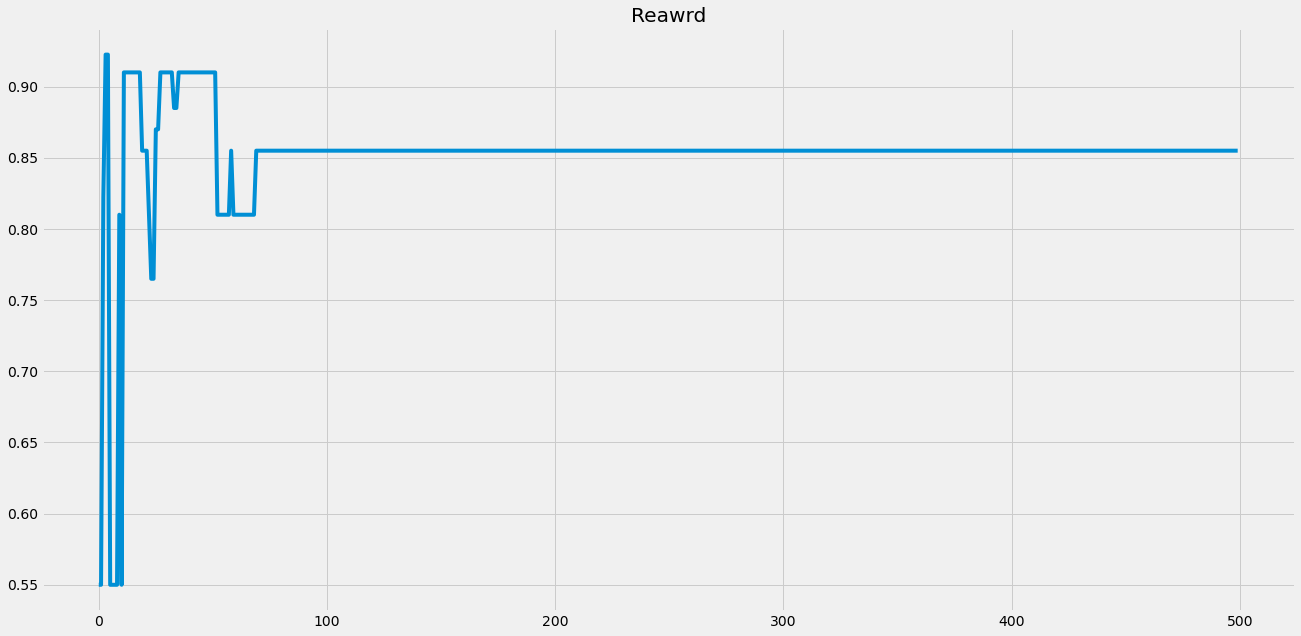

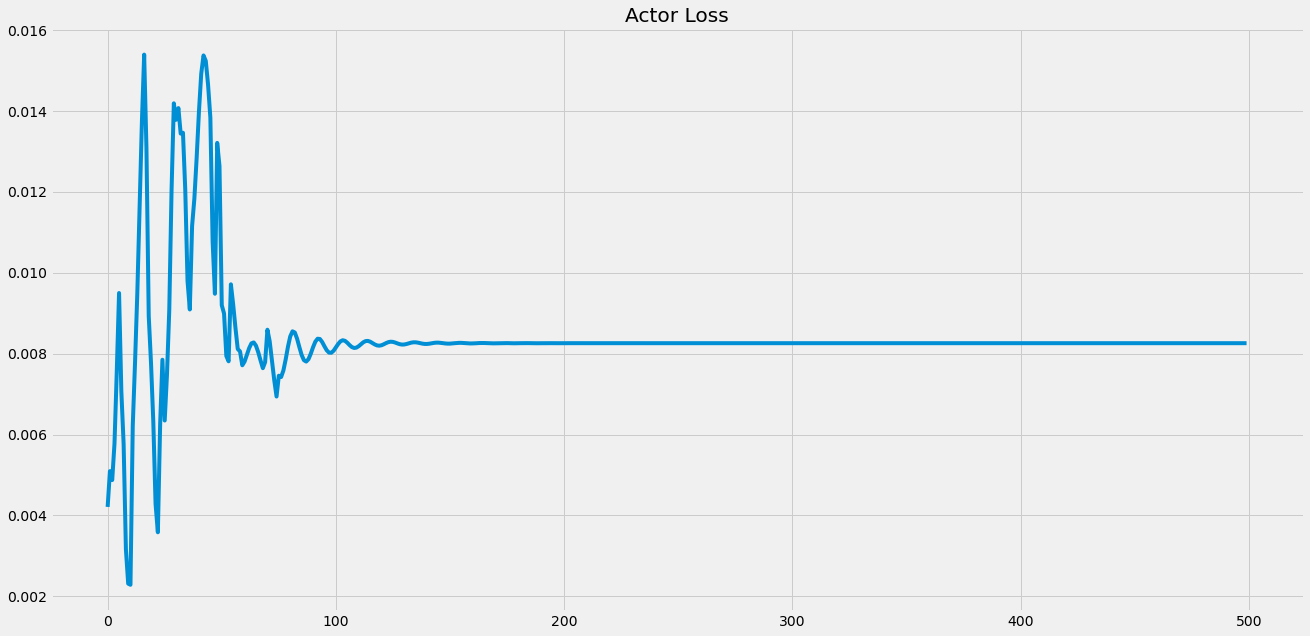

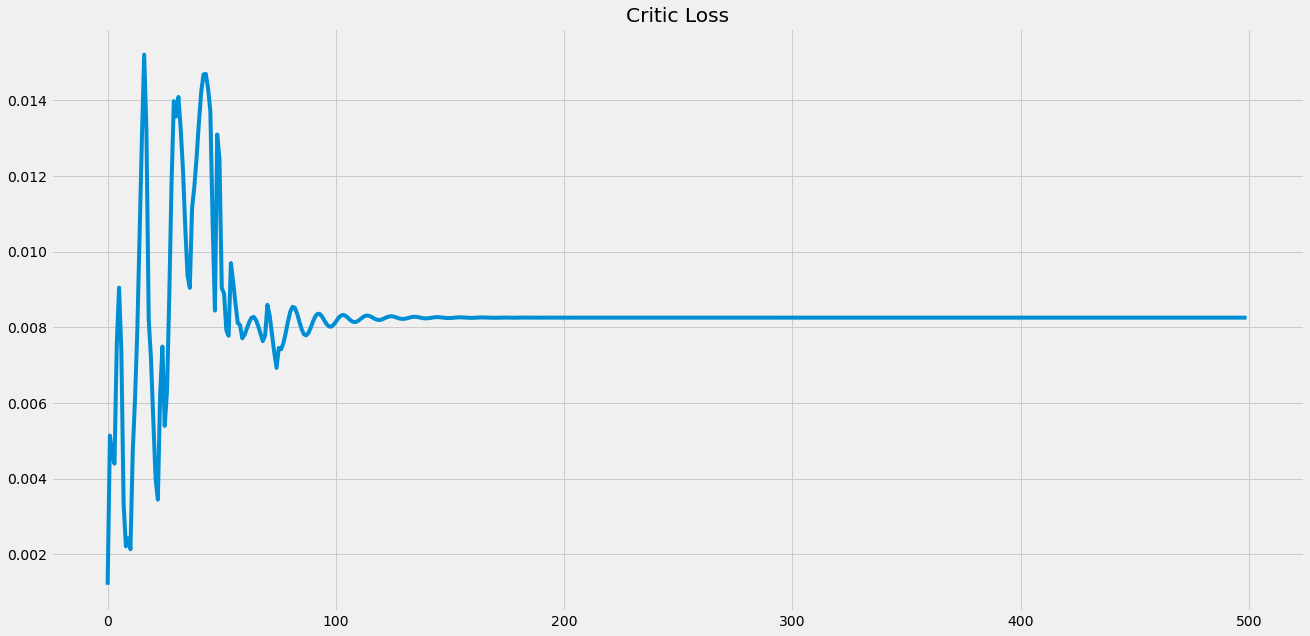

In [30]:
plt.title('Reawrd')
plt.plot(tr_l)
plt.show()

plt.title('Actor Loss')
plt.plot(avg_actor_loss)
plt.show()

plt.title('Critic Loss')
plt.plot(avg_critic_loss)
plt.show()

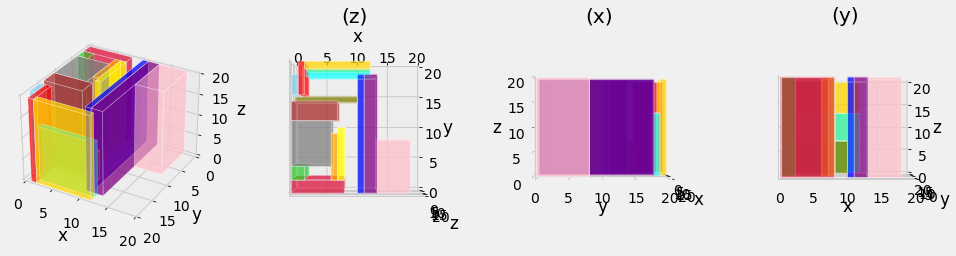

reward: 0.55 actor loss: 0.004210382433874267 critic_loss: 0.0011936335691383906


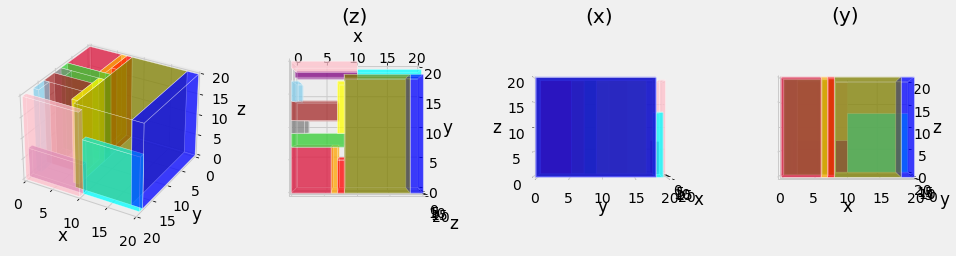

reward: 0.855 actor loss: 0.008152544498443604 critic_loss: 0.008151436490671975


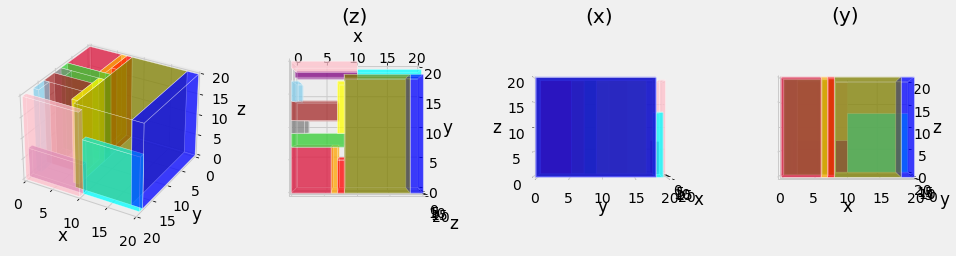

reward: 0.855 actor loss: 0.008258494947637831 critic_loss: 0.008258494947637831


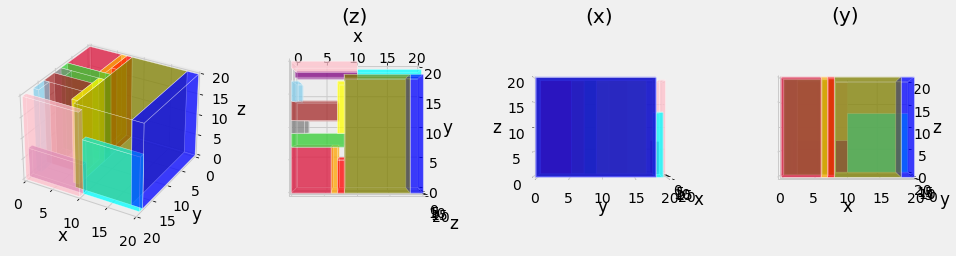

reward: 0.855 actor loss: 0.00825805589556694 critic_loss: 0.008258054831198283


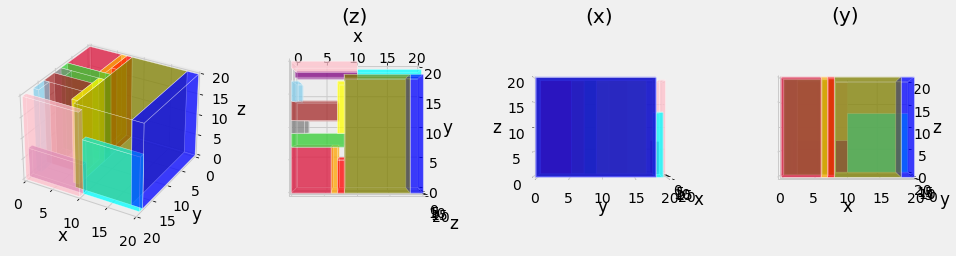

reward: 0.855 actor loss: 0.008258056959935598 critic_loss: 0.008258056959935598


In [32]:
for reward, act_loss, critic_loss, used_boxes, pred_pos in zip(tr_l[::100], avg_actor_loss[::100], avg_critic_loss[::100], used_box_list[::100], pred_pos_list[::100]):
    vis_box_subplot(used_boxes, pred_pos)
    print('reward:',reward,'actor loss:',act_loss,'critic_loss:',critic_loss)

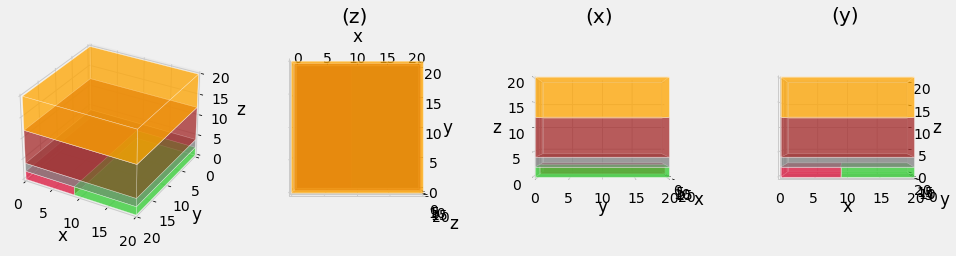

=====episode:     0 | memory length:     3 | env.terminal_reward(): 0.400 | avg actor loss : 0.002215 avg critic loss : 0.001964 time: 1.312
=====episode:     1 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.011362 avg critic loss : 0.007811 time: 0.929
=====episode:     2 | memory length:     3 | env.terminal_reward(): 0.873 | avg actor loss : 0.033286 avg critic loss : 0.007588 time: 1.103
=====episode:     3 | memory length:     3 | env.terminal_reward(): 0.902 | avg actor loss : 0.016551 avg critic loss : 0.010063 time: 0.939
=====episode:     4 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.042133 avg critic loss : 0.040124 time: 0.972
=====episode:     5 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.057775 avg critic loss : 0.057775 time: 0.935
=====episode:     6 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.021005 avg critic loss : 0.008125 time: 0.684
=====episode:

=====episode:    59 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010469 avg critic loss : 0.010209 time: 0.903
=====episode:    60 | memory length:     3 | env.terminal_reward(): 0.978 | avg actor loss : 0.007630 avg critic loss : 0.006603 time: 0.895
=====episode:    61 | memory length:     3 | env.terminal_reward(): 0.950 | avg actor loss : 0.007361 avg critic loss : 0.006765 time: 0.860
=====episode:    62 | memory length:     3 | env.terminal_reward(): 0.887 | avg actor loss : 0.006936 avg critic loss : 0.006782 time: 0.909
=====episode:    63 | memory length:     2 | env.terminal_reward(): 0.550 | avg actor loss : 0.010482 avg critic loss : 0.011002 time: 0.728
=====episode:    64 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.016969 avg critic loss : 0.015373 time: 0.790
=====episode:    65 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.015071 avg critic loss : 0.013989 time: 0.861
=====episode:

=====episode:   118 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.013853 avg critic loss : 0.013802 time: 0.811
=====episode:   119 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.011301 avg critic loss : 0.010865 time: 0.808
=====episode:   120 | memory length:     1 | env.terminal_reward(): 0.970 | avg actor loss : 0.014702 avg critic loss : 0.014702 time: 0.710
=====episode:   121 | memory length:     2 | env.terminal_reward(): 0.800 | avg actor loss : 0.008460 avg critic loss : 0.008086 time: 0.783
=====episode:   122 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010138 avg critic loss : 0.009878 time: 0.832
=====episode:   123 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010629 avg critic loss : 0.010164 time: 0.858
=====episode:   124 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.011251 avg critic loss : 0.011262 time: 0.851
=====episode:

=====episode:   177 | memory length:     3 | env.terminal_reward(): 0.800 | avg actor loss : 0.008234 avg critic loss : 0.007447 time: 0.910
=====episode:   178 | memory length:     1 | env.terminal_reward(): 0.795 | avg actor loss : 0.009882 avg critic loss : 0.009882 time: 0.707
=====episode:   179 | memory length:     2 | env.terminal_reward(): 0.423 | avg actor loss : 0.007283 avg critic loss : 0.008756 time: 0.766
=====episode:   180 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.017022 avg critic loss : 0.017041 time: 0.509
=====episode:   181 | memory length:     3 | env.terminal_reward(): 0.738 | avg actor loss : 0.006823 avg critic loss : 0.006911 time: 1.003
=====episode:   182 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.011712 avg critic loss : 0.011650 time: 0.835
=====episode:   183 | memory length:     1 | env.terminal_reward(): 0.833 | avg actor loss : 0.010829 avg critic loss : 0.010829 time: 0.707
=====episode:

=====episode:   236 | memory length:     3 | env.terminal_reward(): 0.860 | avg actor loss : 0.004180 avg critic loss : 0.004545 time: 0.903
=====episode:   237 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009544 avg critic loss : 0.009503 time: 0.878
=====episode:   238 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010810 avg critic loss : 0.010669 time: 0.867
=====episode:   239 | memory length:     2 | env.terminal_reward(): 0.190 | avg actor loss : 0.001772 avg critic loss : 0.002210 time: 0.755
=====episode:   240 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009909 avg critic loss : 0.009806 time: 0.787
=====episode:   241 | memory length:     2 | env.terminal_reward(): 0.920 | avg actor loss : 0.008917 avg critic loss : 0.008895 time: 1.009
=====episode:   242 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009373 avg critic loss : 0.009644 time: 0.547
=====episode:

=====episode:   295 | memory length:     2 | env.terminal_reward(): 0.730 | avg actor loss : 0.013027 avg critic loss : 0.014094 time: 0.791
=====episode:   296 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.019523 avg critic loss : 0.020129 time: 0.539
=====episode:   297 | memory length:     3 | env.terminal_reward(): 0.930 | avg actor loss : 0.007603 avg critic loss : 0.007534 time: 0.913
=====episode:   298 | memory length:     2 | env.terminal_reward(): 0.810 | avg actor loss : 0.011621 avg critic loss : 0.011262 time: 0.768
=====episode:   299 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.012573 avg critic loss : 0.012265 time: 0.516
=====episode:   300 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.011561 avg critic loss : 0.011260 time: 0.510
=====episode:   301 | memory length:     2 | env.terminal_reward(): 0.756 | avg actor loss : 0.009412 avg critic loss : 0.007465 time: 0.850
=====episode:

=====episode:   354 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.005180 avg critic loss : 0.003303 time: 0.569
=====episode:   355 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010995 avg critic loss : 0.011028 time: 0.919
=====episode:   356 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.013936 avg critic loss : 0.013971 time: 0.793
=====episode:   357 | memory length:     3 | env.terminal_reward(): 0.786 | avg actor loss : 0.005280 avg critic loss : 0.005304 time: 0.822
=====episode:   358 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.021368 avg critic loss : 0.021368 time: 0.861
=====episode:   359 | memory length:     1 | env.terminal_reward(): 0.745 | avg actor loss : 0.008672 avg critic loss : 0.008672 time: 0.712
=====episode:   360 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010616 avg critic loss : 0.010689 time: 0.868
=====episode:

=====episode:   413 | memory length:     1 | env.terminal_reward(): 0.732 | avg actor loss : 0.008378 avg critic loss : 0.008378 time: 0.722
=====episode:   414 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.018729 avg critic loss : 0.018729 time: 0.518
=====episode:   415 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009341 avg critic loss : 0.009452 time: 0.832
=====episode:   416 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010051 avg critic loss : 0.010157 time: 0.864
=====episode:   417 | memory length:     2 | env.terminal_reward(): 0.532 | avg actor loss : 0.005561 avg critic loss : 0.004906 time: 0.807
=====episode:   418 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010994 avg critic loss : 0.010983 time: 0.878
=====episode:   419 | memory length:     2 | env.terminal_reward(): 0.700 | avg actor loss : 0.007324 avg critic loss : 0.007283 time: 0.787
=====episode:

=====episode:   472 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009735 avg critic loss : 0.009963 time: 0.846
=====episode:   473 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009858 avg critic loss : 0.010039 time: 0.852
=====episode:   474 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010599 avg critic loss : 0.010569 time: 0.921
=====episode:   475 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.009824 avg critic loss : 0.009948 time: 0.765
=====episode:   476 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.010324 avg critic loss : 0.010334 time: 0.813
=====episode:   477 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.012547 avg critic loss : 0.012311 time: 0.805
=====episode:   478 | memory length:     2 | env.terminal_reward(): 1.000 | avg actor loss : 0.012096 avg critic loss : 0.011769 time: 0.778
=====episode:

In [33]:
max_episode = 500
N_MDD = 5
K = 3
N_candidates = 4

boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)

num_max_boxes = len(boxes[0])
num_max_remain = num_max_boxes - K
env = Bpp3DEnv()
agent = ActorCriticAgent(L=20,B=20,H=20,n_remains=num_max_remain,
                        lr=0.001,gamma=0.99)

used_box_list, pred_pos_list = [], []
box_list, pos_list = [],[]
tr_l, h_fill, avg_actor_loss, avg_critic_loss, history_eps, used_boxes_eps = [],[],[],[],[],[]
vis_box_subplot(boxes[0], gt_pos[0])

for episode in range(max_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,
                                        N_mdd = N_MDD)
    
    history, used_boxes, remains, comb, pred_pos, actions, s_orders = [],[],[],[],[],[],[]
    next_history, next_comb, next_remains, next_s_orders = [],[],[],[]
    
    boxes_all = np.array(boxes)[0].copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container.copy()
        k = min(K, len(r_boxes))
        step += 1
        
        selected = cbn_select_boxes(r_boxes[:N_candidates], k)
        s_order = get_selected_order(selected, k)
        
        state_h = env.update_h().copy()
        in_state, in_r_boxes = raw_to_input(state_h, s_order,
                                           r_boxes, num_max_remain)
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                             env.height) for s_loc in s_loc_c])
        
        action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        history.append(in_state[action_idx])
        s_loc = s_loc_c[action_idx]
        loaded_mh = get_loaded_mh(s_loc, env.length, env.breadth, env.height)
        comb.append(loaded_mh)
        
        actions.append(action_idx)
        remains.append(in_r_boxes[action_idx])
        env.convert_state(next_cube_c[action_idx])
        
        next_state = env.container.copy()
        next_state_h = env.container_h.copy()
        next_history.append(next_state_h)
        
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes_c[action_idx]
        pred_pos = pred_pos_c[action_idx]
        
        if len(r_boxes) == 0:
            done = True
            next_remains.append(np.zeros((num_max_remain, 3)))
            next_comb.append(np.zeros((1,20,20,2)))
            next_s_orders.append(np.zeros((1,1,3)))
        else:
            next_remains.append(r_boxes)
            k = min(K, len(r_boxes))
            selected = cbn_select_boxes(r_boxes[:N_candidates], k)
            s_order = get_selected_order(selected, k)
            s_loc_c, _,_,_,_,_ = get_selected_location(s_order, pred_pos,
                                                      used_boxes, next_state)
            loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                                 env.height) for s_loc in s_loc_c])
            next_comb.append(loaded_mh_c)
            next_s_orders.append(s_order)
            
            if np.sum(env.container_h != env.height) == 0:
                done = True
                
        if done:
            terminal_reward = env.terminal_reward()
            tr_l.append(terminal_reward)
            h_fill.append(env.terminal_reward())
            
            is_last = False
            N = len(history)
            for i in range(N):
                if i == N-1:
                    is_last = True
                reward = (agent.gamma ** (N-i-1)) * terminal_reward
                in_next_history, in_next_remains = raw_to_input(next_history[i],
                                                               next_s_orders[i],
                                                               next_remains[i],
                                                               num_max_remain)
                
                agent.append_sample(history[i], comb[i], remains[i], actions[i],
                                   reward, is_last, in_next_history,
                                   next_comb[i], in_next_remains)
            agent.train()
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
            used_box_list.append(used_boxes)
            pred_pos_list.append(pred_pos)

    log = "=====episode: {:5d} | ".format(episode)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "env.terminal_reward(): {:.3f} | ".format(env.terminal_reward())
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss = 0
    agent.avg_critic_loss = 0
    agent.memory.clear()

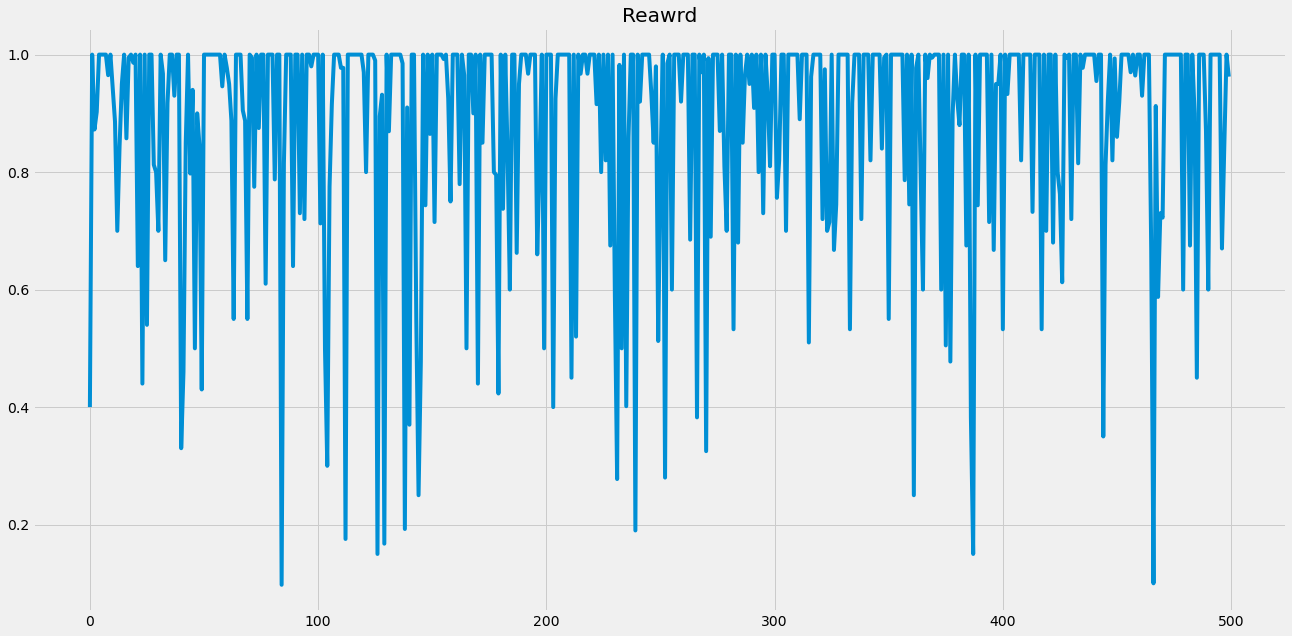

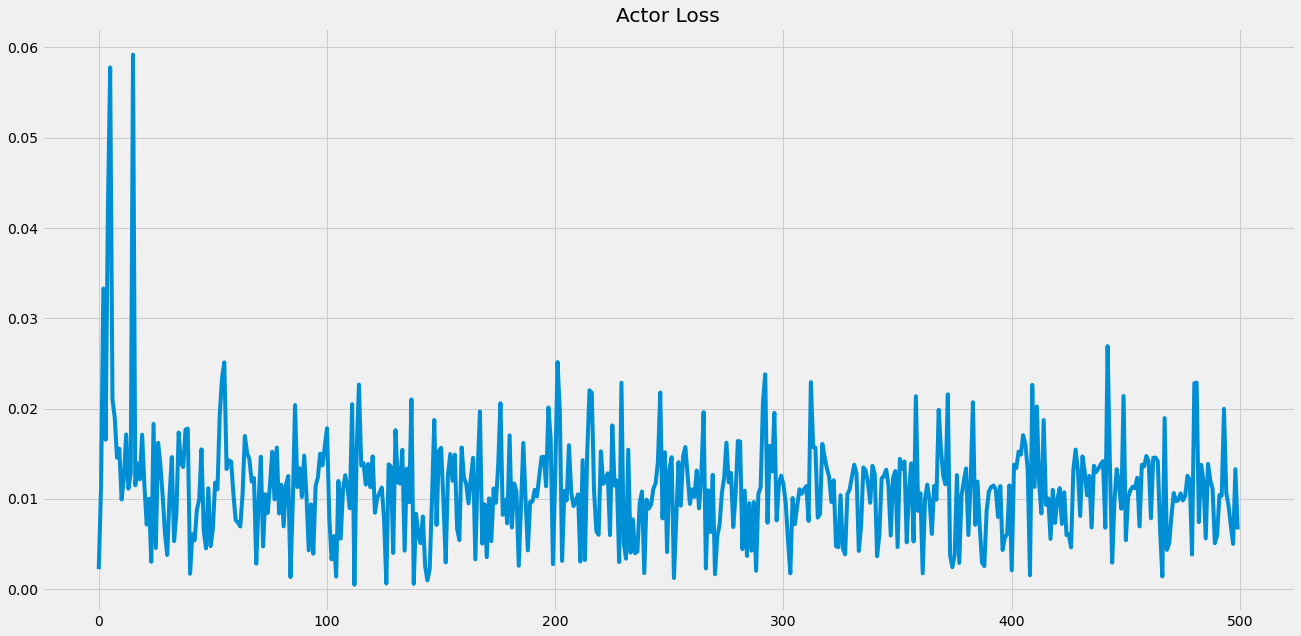

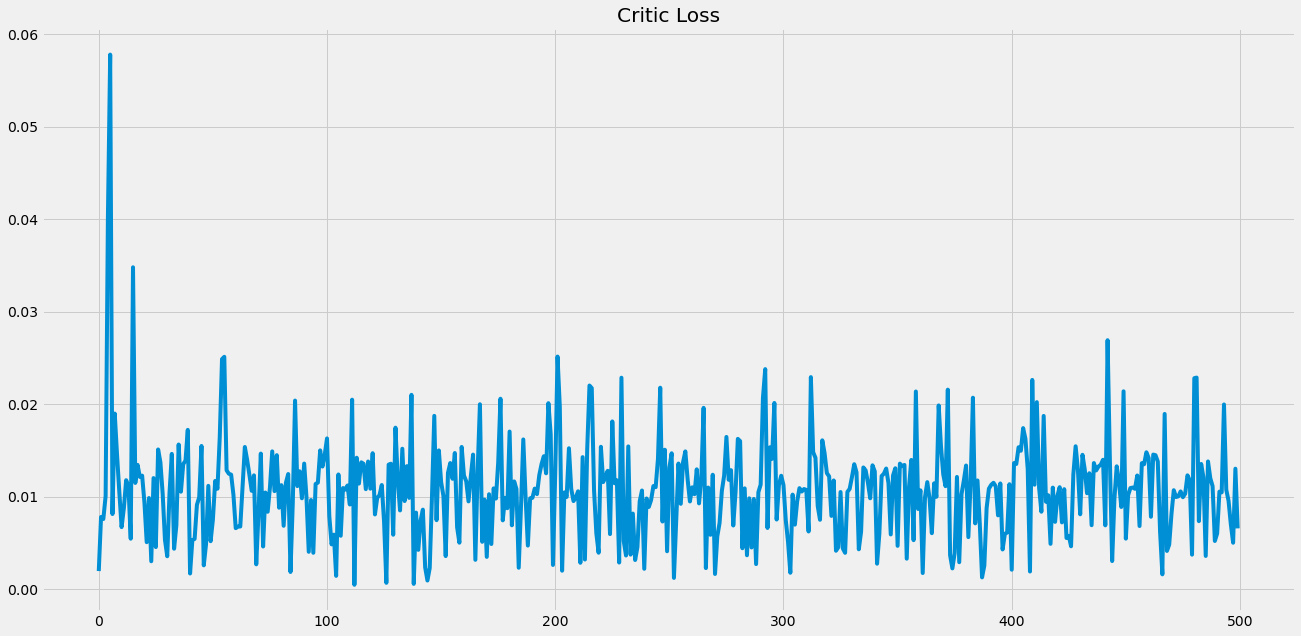

In [34]:
plt.title('Reawrd')
plt.plot(tr_l)
plt.show()

plt.title('Actor Loss')
plt.plot(avg_actor_loss)
plt.show()

plt.title('Critic Loss')
plt.plot(avg_critic_loss)
plt.show()

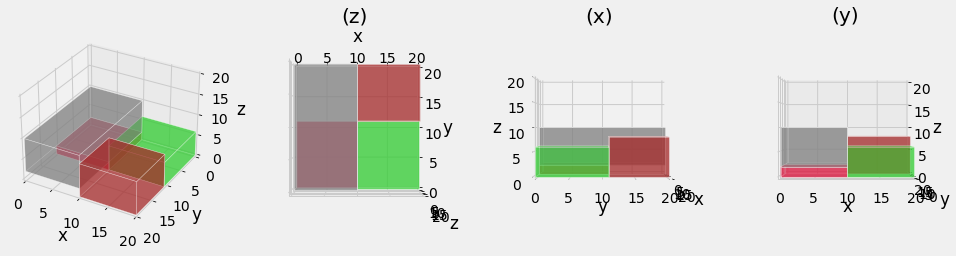

reward: 0.4 actor loss: 0.002215240771571795 critic_loss: 0.0019640419632196426


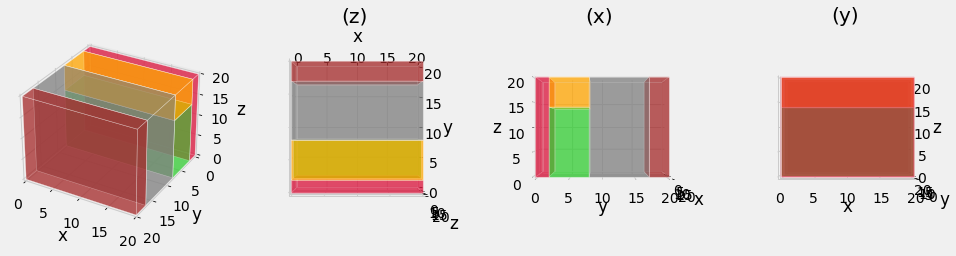

reward: 1.0 actor loss: 0.017817962914705276 critic_loss: 0.016298551112413406


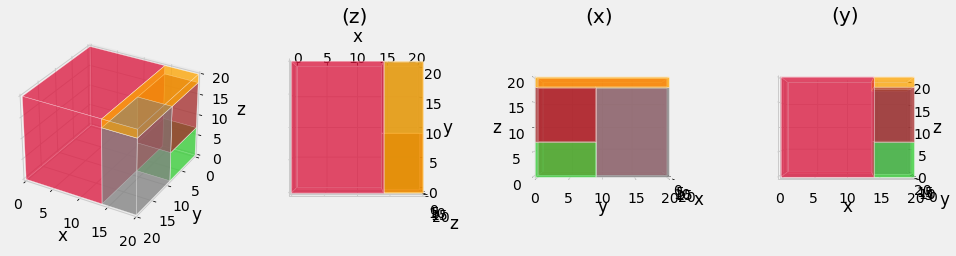

reward: 1.0 actor loss: 0.012624427676200867 critic_loss: 0.01262442022562027


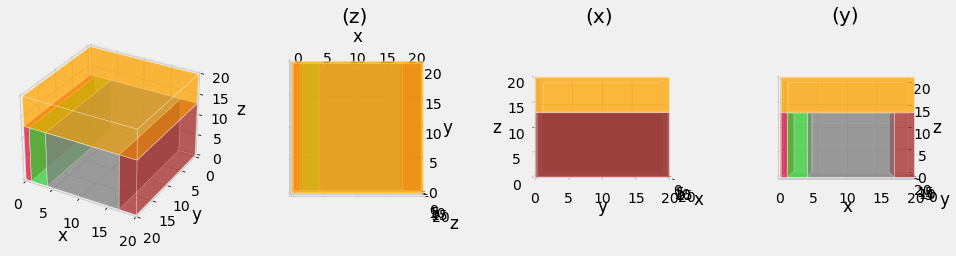

reward: 1.0 actor loss: 0.011561430990695953 critic_loss: 0.01126037910580635


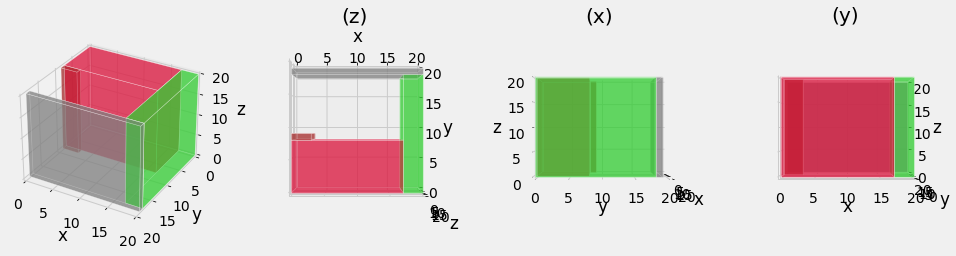

reward: 0.5325 actor loss: 0.002087042356530825 critic_loss: 0.0021113522040347257


In [35]:
for reward, act_loss, critic_loss, used_boxes, pred_pos in zip(tr_l[::100], avg_actor_loss[::100], avg_critic_loss[::100], used_box_list[::100], pred_pos_list[::100]):
    vis_box_subplot(used_boxes, pred_pos)
    print('reward:',reward,'actor loss:',act_loss,'critic_loss:',critic_loss)